In [167]:
from skimage.feature.texture import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage import io
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import numpy as np
import multiprocessing as mp

def get_glcm_features(gray_scale_img)->list[int]:
    """
    Given a grayscale image with graylevels from 0 - 255, this function returns the contrast
    and the homogeneity features of the image with the help of GLCM
    """
    # Tip: Make sure you understand the input-output of everything you write,
    # not doing that results in bugs that make you believe the lab is long
    glcm = graycomatrix(gray_scale_img, distances=[1], angles=[0], levels=256)


    contrast = graycoprops(glcm, "contrast")
    homogeneity = graycoprops(glcm, "homogeneity")
    dissimilarity = graycoprops(glcm, "dissimilarity")
    asm=graycoprops(glcm,"ASM")
    energy=graycoprops(glcm,"energy")
    correlation=graycoprops(glcm,"correlation")
    return [contrast[0][0], homogeneity[0][0],dissimilarity[0][0],asm[0][0],energy[0][0],correlation[0][0]]




In [191]:
import cv2
import mediapipe as mp

sample_size = 500
#print(os.path.abspath(".."))

path_to_hands = "../Hands/"
image_names = os.listdir(path_to_hands)[:sample_size]
fns = [os.path.splitext(fn)[0] for fn in image_names]



def get_hand_bbs(frame, hands, padding=20, draw_on_frame=True):
    """
        Given a frame, detects hand in the image and returns their bounding boxes in image space
        Can add padding onto the bounding boxes if needed.
        Can disable drawing on the frame if needed.
    """

    frame.flags.writeable = False
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame)
    frame.flags.writeable = True

    bboxes = []

    # Draw the hand annotations on the frame.
    if results.multi_hand_landmarks:

        for myHand in results.multi_hand_landmarks:
            xList = []
            yList = []
            for id, lm in enumerate(myHand.landmark):
                xList.append(lm.x)
                yList.append(lm.y)

            h, w, c = frame.shape
            xmin, xmax = max(int(min(xList) * w) - padding,
                             0), min(int(max(xList) * w) + padding, w)

            ymin, ymax = max(int(min(yList) * h) - padding,
                             0), min(int(max(yList) * h) + padding, h)

            # bboxInfo = {"id": id, "bbox": bbox,"center": (cx, cy)}
            bboxes.append(((xmin, ymin), (xmax, ymax)))

            if draw_on_frame:
                cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0),
                              2)

    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    return frame, bboxes

sift = cv2.SIFT_create()

#pool = mp.Pool(processes=4)

mp_hands = mp.solutions.hands


gray_scale_images=[]
with mp_hands.Hands(
    model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    static_image_mode=True,
    max_num_hands=1,
)as hands:
    for img_path in tqdm(image_names):
        
        img = cv2.imread(path_to_hands + img_path)
        gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #gray=(rgb2gray(io.imread(path_to_hands + img_path)) * 255).astype(np.uint8)
        
        #f,bs=get_hand_bbs(img,hands)
        
        #((xmin,ymin),(xmax,ymax))=bs[0]
        kp= sift.detect(gray)

        img=cv2.drawKeypoints(gray,kp,None)

        gray_scale_images.append(rgb2gray(img))
#def lam(img):  return (rgb2gray(io.imread(path_to_hands + img)) * 255).astype(np.uint8)
#gray_scale_images=pool.map(lam,tqdm(image_names))


 23%|██▎       | 117/500 [00:34<01:54,  3.36it/s]


KeyboardInterrupt: 

In [25]:
# You don't need to understand how this function works
def plot_2d_features_with_names(names_fts_list, xlabel, ylabel):
    x = [names_fts[1][0] for names_fts in names_fts_list]
    y = [names_fts[1][1] for names_fts in names_fts_list]
    txts = [names_fts[0] for names_fts in names_fts_list]

    fig, ax = plt.subplots()
    ax.scatter(x, y)

    for i, txt in enumerate(txts):
        ax.annotate(txt, (x[i], y[i]))
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig = plt.gcf()
    fig.set_size_inches(13, 8)


def plot_1d_features_with_names(names_fts_list, xlabel,findex):
    x = [names_fts[1][findex] for names_fts in names_fts_list]
    #y = [names_fts[1][1] for names_fts in names_fts_list]
    txts = [names_fts[0] for names_fts in names_fts_list]
    y=np.zeros(len(x))
    fig, ax = plt.subplots()
    ax.scatter(x,y)

    for i, txt in enumerate(txts):
        ax.annotate(txt, (x[i],0))
    ax.grid()
    ax.set_xlabel(xlabel)
    #ax.set_ylabel(ylabel)
    fig = plt.gcf()
    fig.set_size_inches(15, 1)


In [112]:

fn_ft_list = np.array([
    #("", get_glcm_features(img)) for fn, img in tqdm(zip(fns, gray_scale_images))
    get_glcm_features(img) for  img in tqdm(gray_scale_images)
])


100%|██████████| 500/500 [00:03<00:00, 145.46it/s]


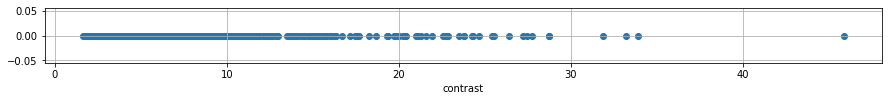

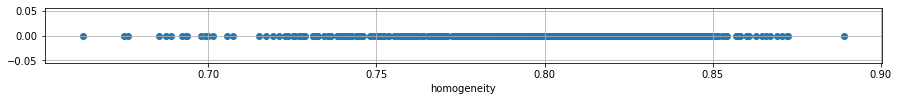

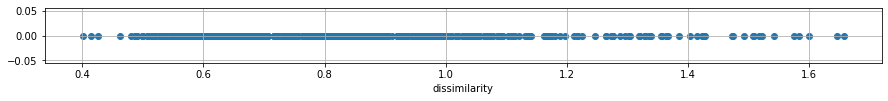

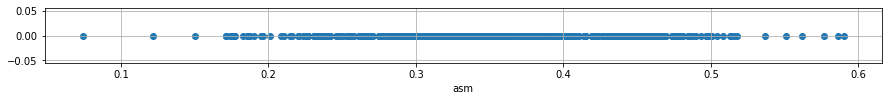

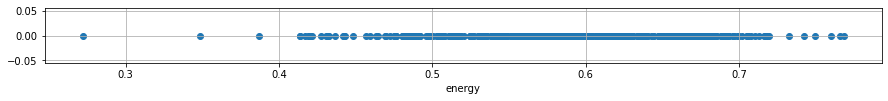

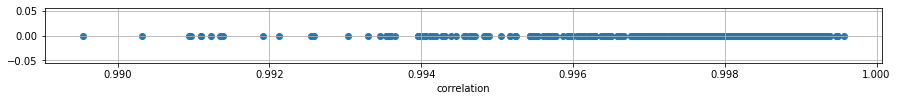

In [101]:
fts={"contrast":0, "homogeneity":1,"dissimilarity":2,"asm":3,"energy":4,"correlation":5}

plot_1d_features_with_names(fn_ft_list, "contrast",fts["contrast"])
plot_1d_features_with_names(fn_ft_list, "homogeneity",fts["homogeneity"])
plot_1d_features_with_names(fn_ft_list, "dissimilarity",fts["dissimilarity"])
plot_1d_features_with_names(fn_ft_list, "asm",fts["asm"])
plot_1d_features_with_names(fn_ft_list, "energy",fts["energy"])
plot_1d_features_with_names(fn_ft_list, "correlation",fts["correlation"])


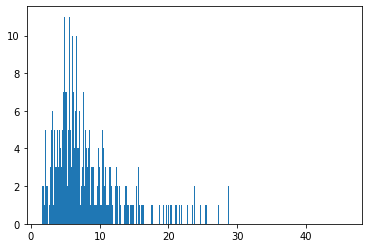

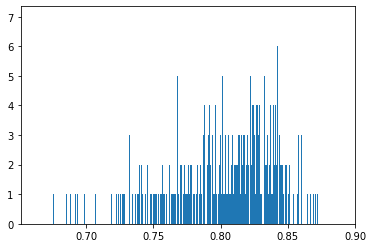

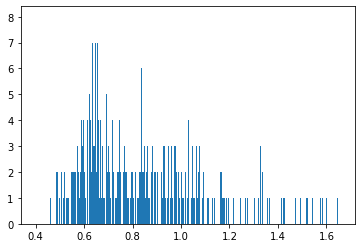

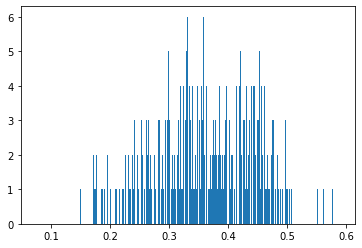

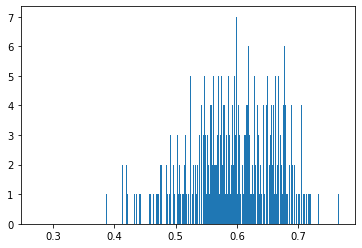

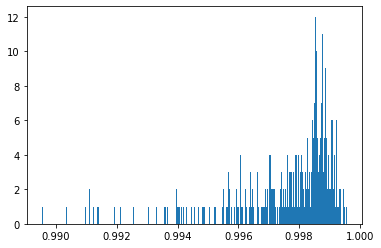

In [121]:
from numpy import histogram
from matplotlib.pyplot import bar
def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    #imgHist = histogram(img, bins=500 )
    
    plt.hist(img,bins=500)


showHist(fn_ft_list[:,0])
showHist(fn_ft_list[:,1])
showHist(fn_ft_list[:,2])
showHist(fn_ft_list[:,3])
showHist(fn_ft_list[:,4])
showHist(fn_ft_list[:,5])
#plt.hist(fn_ft_list[:,0],bins=500)
#plt.hist(fn_ft_list[:,1],bins=500)
#plt.hist(fn_ft_list[:,2],bins=500)
#plt.hist(fn_ft_list[:,3],bins=500)
#plt.hist(fn_ft_list[:,4],bins=500)
#plt.hist(fn_ft_list[:,5],bins=500)


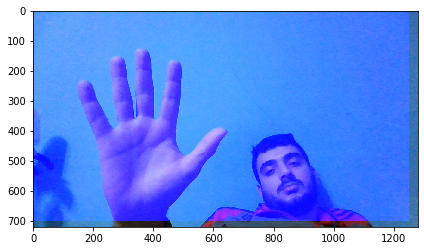

[10.22673964034402, 0.6141304387930162, 1.204478325080358, 0.003255805392972593, 0.05705966520207241, 0.99581875169018]


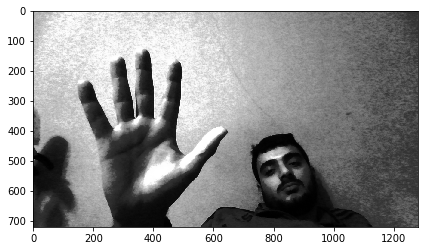

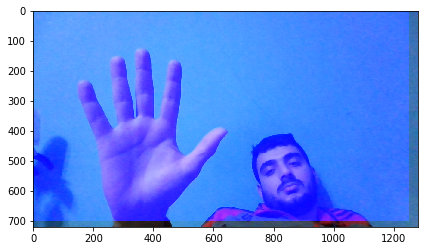

In [166]:
from functools import reduce
from skimage import exposure
from skimage import filters
from cv2 import medianBlur

myHand=io.imread("./0.jpg")

#io.imshow(myHand)

def classify_patch(contrast, homogeneity):
    """
    Given the contrast and homogeneity values of a certain image patch, this function 
    will return the class of the patch, i.e either 'jeans', 'cotton', or 'background'
    """
    # Hint: We can decide whether the patch is background or not by simply checking 'if' the homogeneity is greater than a certain float value
    if  (0.7<homogeneity <0.85) and (8<contrast < 20):
        return "hand"
    return None

def segment_img(image):
    img = image.copy()
    patch_height = patch_width = 50
    width, height,nchannels = img.shape
    # TODO complete the following skeleton
    horizontal_patches = int(width/patch_width)
    vertical_patches = int(height/patch_height)
    # loop on the image patch by patch
    for i in range(1, horizontal_patches+1):
        for j in range(1, vertical_patches+1):
            patch = img[(i-1)*patch_width:i*patch_width, (j-1)*patch_height:j*patch_height]
            
            patch_grayscale = (rgb2gray(patch) * 255).astype(np.uint8)

            [contrast, homogeneity] = get_glcm_features(patch_grayscale)[0:2]
            classification = classify_patch(contrast, homogeneity)

            if classification == 'hand':
                patch[:, :, 1] = 255
            else:
                patch[:, :, 2] = 255

    return img

def getImageWithHist(image):
    # image=io.imread(name)
    G_levels = 256
    img = (255 * np.array(rgb2gray(image))).astype(np.uint8)
    H = histogram(img)[0]
    H_c = reduce(lambda ls, a: ls + [a + ls[-1]], H[1:], [H[0]])
    outputImage = (
        255
        * np.array(
            [
                [
                    round(
                        (G_levels - 1)
                        * H_c[pixelIntensity]
                        / (img.shape[0] * img.shape[1])
                    )
                    for pixelIntensity in row
                ]
                for row in img
            ]
        )
    ).astype(np.uint8)
    return outputImage

def Contrast_enhancement(image):
    img = (255*np.array(rgb2gray(image))).astype(np.uint8)
    H_img,W_img=img.shape
    #outputImage = np.array([[ 1.5*x+50 if x<100 else x  for x in y] for y in img ])
    outputImage=np.zeros(img.shape)
    for y in range(0,H_img):
        for x in range(0,W_img):
            if( img[y][x] <= 100):
                outputImage[y][x] =1.5*img[y][x]+50
            else:
                outputImage[y][x]= img[y][x]
    return outputImage

def Gamma_Correct(image, c, g):
    img = (255 * np.array(rgb2gray(image))).astype(np.uint8)
    H_img, W_img = img.shape
    # outputImage = (255*np.array([[ c*((x/255)**g)  for x in y] for y in img ])).astype(np.uint8) 
    outputImage = np.zeros(img.shape)
    for y in range(0, H_img):
        for x in range(0, W_img):
            outputImage[y][x] = np.uint8(255 * (c * (img[y][x] / 255) ** g))
    return outputImage
